In [1]:
import bayes3d as b
import genjax
import jax.numpy as jnp
import jax
import os

console = genjax.pretty(show_locals=False)

In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=50.0, fy=50.0,
    cx=50.0, cy=50.0,
    near=0.001, far=6.0
)

b.setup_renderer(intrinsics)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(),"sample_objs/cube.obj"))
model_dir = os.path.join(b.utils.get_assets_dir(), "bop/ycbv/models")
IDX = 13
mesh_path_ply = os.path.join(model_dir,"obj_" + "{}".format(IDX+1).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path_ply, scaling_factor=1.0/100.0)


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [4]:
from dataclasses import dataclass
from math import pi

import jax
import jax.numpy as jnp

from genjax._src.generative_functions.distributions.distribution import ExactDensity


@dataclass
class GaussianVMFPose(ExactDensity):
    def sample(self, key, pose_mean, var, concentration, **kwargs):
        return b.distributions.gaussian_vmf_sample(key, pose_mean, var, concentration)

    def logpdf(self, pose, pose_mean, var, concentration, **kwargs):
        return b.distributions.gaussian_vmf_logpdf(pose, pose_mean, var, concentration)

@dataclass
class ImageLikelihood(ExactDensity):
    def sample(self, key, rendered_image, variance, outlier_prob, outlier_volume, **kwargs):
        return rendered_image

    def logpdf(self, image, rendered_image, variance, outlier_prob, outlier_volume, **kwargs):
        return b.threedp3_likelihood(image, rendered_image, variance, outlier_prob, outlier_volume,5)

gaussian_vmf_pose = GaussianVMFPose()
image_likelihood = ImageLikelihood()

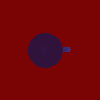

In [6]:
center_pose = b.t3d.transform_from_pos(jnp.array([0.0, 0.0, 1.5]))
img = b.RENDERER.render_single_object(center_pose, 0)
b.get_depth_image(img[:,:,2])

In [22]:
@genjax.gen
def scene(variance, outlier_prob, outlier_volume):
    pose = genjax.trace("pose", gaussian_vmf_pose)(center_pose, 0.1, 0.00001)
    rendered_img = b.RENDERER.render_single_object(pose, 0)[:,:,:3]
    image = genjax.trace("image", image_likelihood)(rendered_img, variance, outlier_prob, outlier_volume)
    return rendered_img

simulate_jit = jax.jit(scene.simulate)
importance_jit = jax.jit(scene.importance)
importance_parallel_jit = jax.jit(jax.vmap(scene.importance, in_axes=(0, None, None)))

In [23]:
key = jax.random.PRNGKey(0)

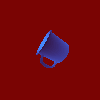

In [119]:
key, gt_trace= simulate_jit(key, (0.01,0.01, 10.0,))
observed_image = gt_trace.get_retval()
observations = genjax.choice_map({"image": observed_image})
b.get_depth_image(gt_trace.get_retval()[:,:,2])


In [120]:
num_images = 6000
keys = jax.random.split(key, num_images)
keys = jax.random.split(key, num_images)

-34911.734
CPU times: user 291 ms, sys: 164 µs, total: 291 ms
Wall time: 287 ms


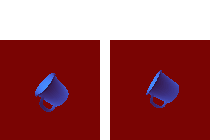

In [128]:
%%time
keys, (weights, traces) = importance_parallel_jit(keys, observations, (0.01,0.01, 10.0,))
print(weights.max())
b.multi_panel([b.get_depth_image(traces.get_retval()[weights.argmax(),:,:,2]), b.get_depth_image(traces["image"][0,:,:,2])])

In [122]:
b.utils.normalize_log_scores(jnp.array([-33950.92,-34027.727
]))

Array([1.0000000e+00, 4.4070505e-34], dtype=float32)